In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer

from catboost import Pool, cv,CatBoostRegressor

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
train_df.shape

(16967, 21)

In [4]:
data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()

In [5]:
data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference'],
      dtype='object')

In [6]:
cat_features = ['pick_cluster','is_more_than_one_day','pickup_timeslot',
       'day_of_week', 'is_weekday']

features = [
    'additional_fare',
#     'duration', 
#     'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pick_cluster', 
    'is_more_than_one_day', 
    'distance_km',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday'
]

In [7]:
X = data[features]
y = data['fare'].values

In [8]:
train_df_X = train_df[features]
train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
test_df_X = test_df[features]
test_df_pool = Pool(data=test_df_X,cat_features=cat_features)

In [9]:
train_df_preds = np.zeros(train_df.shape[0])
test_df_preds = np.zeros(test_df.shape[0])

In [10]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [11]:
kf = KFold(n_splits=3)

In [12]:
validation_scores = []
models = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostRegressor(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    validation_score = model.best_score_['validation']['RMSE']
    print('Validation RMSE',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    
    train_df_preds += model.predict(train_df_pool)
    test_df_preds += model.predict(test_df_pool)

Learning rate set to 0.071592
0:	learn: 356.2246812	test: 273.4161084	best: 273.4161084 (0)	total: 62.8ms	remaining: 1m 2s
10:	learn: 275.5670021	test: 206.6536141	best: 206.6536141 (10)	total: 123ms	remaining: 11.1s
20:	learn: 233.1340994	test: 187.8602663	best: 187.8602663 (20)	total: 167ms	remaining: 7.77s
30:	learn: 203.8378640	test: 176.9119107	best: 176.9119107 (30)	total: 224ms	remaining: 7s
40:	learn: 178.5406336	test: 164.7783956	best: 164.7783956 (40)	total: 270ms	remaining: 6.32s
50:	learn: 156.9122025	test: 155.5272059	best: 155.5272059 (50)	total: 315ms	remaining: 5.86s
60:	learn: 140.9967817	test: 149.0205940	best: 149.0205940 (60)	total: 361ms	remaining: 5.56s
70:	learn: 128.5463631	test: 143.4419639	best: 143.4419639 (70)	total: 403ms	remaining: 5.27s
80:	learn: 119.2361364	test: 139.8196888	best: 139.8196888 (80)	total: 467ms	remaining: 5.29s
90:	learn: 112.3809124	test: 137.6703682	best: 137.6703682 (90)	total: 508ms	remaining: 5.07s
100:	learn: 107.1703853	test: 136.

In [36]:
np.mean(validation_scores), np.std(validation_scores)

(194.98833457612469, 96.06419309381121)

In [37]:
best_model = models[np.argmax(validation_scores)]

In [38]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,distance_km,52.403135
1,meter_waiting_fare,35.657614
2,is_more_than_one_day,6.641491
3,meter_waiting_till_pickup,3.066598
4,additional_fare,0.817130
5,pickup_timeslot,0.626137
6,pick_cluster,0.412176
7,day_of_week,0.299920
8,is_weekday,0.075797


In [16]:
train_df['predicted_fare'] = train_df_preds/3
test_df['predicted_fare'] = test_df_preds/3

In [17]:
train_df['predicted_fare_difference'] = train_df['fare'] - train_df['predicted_fare']
test_df['predicted_fare_difference'] = test_df['fare'] - test_df['predicted_fare']

In [18]:
train_df['predicted_fare_difference_per_fare'] = train_df['predicted_fare_difference'] / (train_df['fare']+1)
test_df['predicted_fare_difference_per_fare'] = test_df['predicted_fare_difference']  / (test_df['fare']+1)

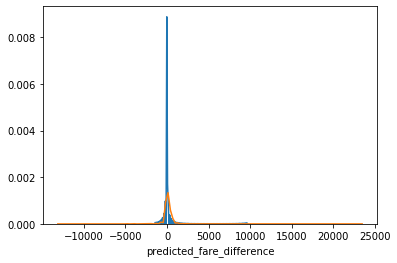

In [19]:
sns.distplot(train_df[train_df['label']==1]['predicted_fare_difference'], hist=False)
sns.distplot(train_df[train_df['label']==0]['predicted_fare_difference'], hist=False)

In [20]:
train_df[train_df['label']==1]['predicted_fare_difference'].describe()

count    15441.000000
mean         0.431176
std        125.704468
min      -1410.410600
25%        -36.280513
50%        -11.620245
75%         19.370346
max       9664.032202
Name: predicted_fare_difference, dtype: float64

In [21]:
train_df[train_df['label']==0]['predicted_fare_difference'].describe()

count     1526.000000
mean       138.788543
std       1424.977659
min     -12929.989769
25%        -53.764118
50%         44.217855
75%        322.617993
max      23250.554046
Name: predicted_fare_difference, dtype: float64

In [22]:
# train_df = train_df.drop(['predicted_fare'],axis=1)
# test_df = test_df.drop(['predicted_fare'],axis=1)

In [23]:
train_df.to_csv('train_df_reg.csv',index=False)
test_df.to_csv('test_df_reg.csv',index=False)